In [42]:
from simulate import HawkesProcess
import matplotlib.pyplot as plt

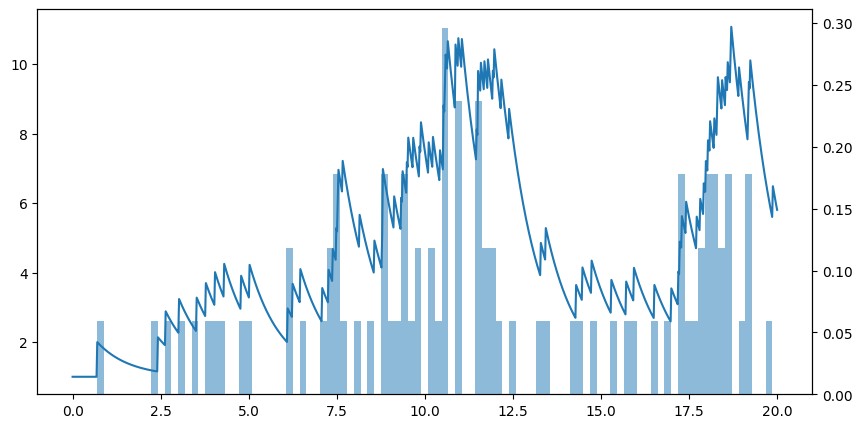

In [43]:
mu, alpha, beta = 1, 1, 1.1
hwk = HawkesProcess(mu, alpha, beta)
T = 20
events = hwk.simulate(T)

intensity_function = lambda t: hwk.get_rate(events, t)
time = np.linspace(0, T, 1000)
intensity = [intensity_function(t) for t in time]
plt.figure(figsize=(10, 5))
plt.plot(time, intensity)
# plt.plot(events, np.zeros(len(events)), marker='x', ls="")
plt.twinx()
plt.hist(events, bins=100, density=True, alpha=0.5)
plt.show()